In [81]:
import pandas as pd

import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json 
import seaborn as sns 

In [82]:
plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",
        "axes.titlesize": 24,        # Larger axes/title fonts
        "legend.fontsize": 24,
    }
)
sns.set_context("talk")


In [83]:
palette_name = 'ocean_sunset'
palette = json.load(open(f'../palettes/{palette_name}.json', 'r'))

In [84]:
palette

{'Rich black': '#001219',
 'Midnight green': '#005f73',
 'Dark cyan': '#0a9396',
 'Tiffany Blue': '#94d2bd',
 'Vanilla': '#e9d8a6',
 'Gamboge': '#ee9b00',
 'Alloy orange': '#ca6702',
 'Rust': '#bb3e03',
 'Rufous': '#ae2012',
 'Auburn': '#9b2226'}

## Sampling collisions

In [85]:
output_dir = '../figures/sampling_collisions'
model_names = ['gemma-3-1b-pt', 'gemma-3-4b-pt', 'gemma-3-12b-pt', 'gpt2', 'gpt2-medium', 'gpt2-large'] #  'Llama-3.1-8B', 'Mistral-7B-v0.1', 'Phi-4-mini-instruct', 'TinyStories-1M', 'TinyStories-8M', 'TinyStories-33M'

In [86]:
model_name_to_data = {}
filename_fn = lambda x: f'{x}-layer-stats.csv'

for model in model_names:

    df = pd.read_csv(f'../data/sampling_collisions/{filename_fn(model)}')
    model_name_to_data[model] = df
    print(df.head())

   layer       count        mean         std       min          max
0      1  4999950000  388.000867   81.484355  0.690545  1221.549438
1      2  4999950000  454.868565   83.023647  1.488919  1197.440063
2      3  4999950000  522.992854   88.149104  2.125064  1582.803589
3      4  4999950000  636.365883  139.904533  2.682702  1849.554932
4      5  4999950000  756.525868  315.431737  5.326268  6730.736328
   layer       count         mean          std       min           max
0      1  4999950000   755.600975   570.572009  0.581290  10856.806641
1      2  4999950000   787.215231   586.668592  1.633421  11545.596680
2      3  4999950000   885.661262   788.778374  1.971468  17010.734375
3      4  4999950000   948.739379   916.405098  2.184747  19956.787109
4      5  4999950000  1184.181242  1409.029561  4.980736  31204.494141
   layer       count         mean          std       min           max
0      1  4999950000   889.823674   562.720207  0.896930   8438.365234
1      2  4999950000   8

## Per-model box plots

In [87]:
Z_25 = 0.6744897501960817  # Φ^{-1}(0.75) for normal ≈ 0.67449

def _safe_float(x):
    try:
        return float(x)
    except Exception:
        return np.nan

def stats_row_to_bxp_dict(row):
    """
    Convert a row with (layer, mean, std, min, max) to a dict for matplotlib.bxp.
    Expected row fields: 'layer', 'mean', 'std', 'min', 'max'
    """
    lyr = int(row["layer"])
    mu  = _safe_float(row["mean"])
    sd  = _safe_float(row["std"])
    mn  = _safe_float(row["min"])
    mx  = _safe_float(row["max"])

    # Fallbacks if missing/NaN
    if np.isnan(mu): mu = 0.0
    if np.isnan(sd): sd = 0.0
    if np.isnan(mn): mn = mu
    if np.isnan(mx): mx = mu

    # Ensure min <= max
    if mx < mn:
        mn, mx = mx, mn

    # Approximate quartiles (normal assumption), then clamp to [min, max]
    q1 = mu - Z_25 * sd
    q3 = mu + Z_25 * sd
    med = mu

    q1 = min(max(q1, mn), mx)
    q3 = min(max(q3, mn), mx)
    med = min(max(med, mn), mx)

    # If q1 > q3 (pathological due to clamping), collapse to median
    if q1 > q3:
        q1 = q3 = med = min(max(mu, mn), mx)

    return {
        "label": f"{lyr}",
        "whislo": mn,   # bottom whisker
        "q1": q1,       # 25th percentile
        "med": med,     # median (here: mean, clamped)
        "q3": q3,       # 75th percentile
        "whishi": mx,   # top whisker
        "fliers": []
    }

In [88]:
def plot_model_boxplot(df, model: str, figsize=None, ax=None):
    # Expect columns: layer, count, mean, std, min, max
    required = {"layer", "mean", "std", "min", "max"}
    missing = required - set(map(str.lower, df.columns))
    if missing:
        # Try case-insensitive rename
        lower_map = {c.lower(): c for c in df.columns}
        df = df.rename(columns={lower_map.get(k, k): k for k in required if k in lower_map})

    # Sort by layer
    if "layer" in df.columns:
        df = df.sort_values("layer")

    # Build bxp stats list
    bxp_stats = [stats_row_to_bxp_dict(row) for _, row in df.iterrows()]

    # Create figure/axes if not provided
    created_fig = False
    if ax is None:
        figsize = figsize if figsize is not None else (max(8, len(bxp_stats) * 0.35), 5)
        fig, ax = plt.subplots(figsize=figsize)
        created_fig = True
    else:
        fig = ax.figure

    # Plot boxplot
    ax.bxp(
        bxp_stats,
        showfliers=False,
        widths=0.6,
        medianprops=dict(color=palette['Auburn'], linewidth=1.8)
    )

    ax.set_xlabel("Layer", fontsize=24)
    ax.set_ylabel("Value", fontsize=24)

    # Improve readability
    ax.grid(axis="y", linestyle="--", alpha=0.4)

    ax.tick_params(axis="x", labelrotation=0, labelsize=28, pad=8, width=0.5)
    ax.tick_params(axis="y", labelsize=28, width=0.5)
    ax.tick_params(axis="y", which="minor", width=0.0, length=3)
    ax.tick_params(axis="y", which="major", width=1.2, length=6)

    # log scale if all > 0
    all_vals = []
    for b in bxp_stats:
        all_vals.extend([b["whislo"], b["q1"], b["med"], b["q3"], b["whishi"]])
    if all(v > 0 for v in all_vals):
        ax.set_yscale("log")

    # === Global minimum line ===
    global_min = min(b["whislo"] for b in bxp_stats)
    ax.axhline(global_min, linestyle=":", linewidth=1.5,
               color=palette['Midnight green'], alpha=0.9, zorder=9)
    ax.annotate(
        f"minimum distance: {global_min:.2f}",
        xy=(0.5, global_min), xycoords=("axes fraction", "data"),
        xytext=(0, 5), textcoords="offset points",
        ha="center", va="bottom",
        fontsize=28, color=palette['Midnight green'],
        bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.7)
    )

    # Adjust y-limits with extra headroom
    ymax = max(b["whishi"] for b in bxp_stats)
    pad = max(1e-6, 0.05 * ymax)
    ax.set_ylim(global_min - pad, ymax + 2 * pad)

    # Save only if created here
    if created_fig:
        out_path = os.path.join(output_dir, f"{model}-layer-boxplot.pdf")
        plt.savefig(out_path, dpi=300, bbox_inches='tight')
        plt.close(fig)


In [89]:
for model in model_names:
    df = model_name_to_data[model]

    plot_model_boxplot(df, model)

/tmp/ipykernel_1949008/2950696303.py:68: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(global_min - pad, ymax + 2 * pad)
/tmp/ipykernel_1949008/2950696303.py:68: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(global_min - pad, ymax + 2 * pad)
/tmp/ipykernel_1949008/2950696303.py:68: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(global_min - pad, ymax + 2 * pad)
/tmp/ipykernel_1949008/2950696303.py:68: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(global_min - pad, ymax + 2 * pad)
/tmp/ipykernel_1949008/2950696303.py:68: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(global_min - pad, ymax + 2 * pad)
/tmp/ipykernel_1949008/2950696303.py:68: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_y

In [90]:
plot_model_boxplot(model_name_to_data['gpt2'], 'gpt2', figsize=(14, 9))

/tmp/ipykernel_1949008/2950696303.py:68: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(global_min - pad, ymax + 2 * pad)


## Combined plot

In [91]:
def plot_all_models_boxplots(model_name_to_data, model_names, output_dir, model_family):
    n_models = len(model_names)

    fig, axes = plt.subplots(
        n_models, 1,
        figsize=(12, 2.5 * n_models),  # height scales with number of models
        sharex=True, sharey=True        # align axes
    )

    if n_models == 1:
        axes = [axes]  # ensure iterable

    for ax, model in zip(axes, model_names):
        df = model_name_to_data[model]

        # Ensure columns present
        required = {"layer", "mean", "std", "min", "max"}
        lower_map = {c.lower(): c for c in df.columns}
        df = df.rename(columns={lower_map.get(k, k): k for k in required if k in lower_map})

        if "layer" in df.columns:
            df = df.sort_values("layer")

        # Build bxp stats list
        bxp_stats = [stats_row_to_bxp_dict(row) for _, row in df.iterrows()]

        # Draw boxplot
        ax.bxp(
            bxp_stats,
            showfliers=False,
            widths=0.6,
            medianprops=dict(color=palette['Auburn'], linewidth=1.8)
        )

        # Labels & title
        ax.set_ylabel("Value", fontsize=14)
        ax.set_title(model, fontsize=16, pad=10)

        # Grid & ticks
        ax.grid(axis="y", linestyle="--", alpha=0.4)
        ax.tick_params(axis="x", labelrotation=0, labelsize=12, pad=6, width=0.8, length=4)
        ax.tick_params(axis="y", labelsize=12, width=0.8, length=6)
        ax.tick_params(axis="y", which="minor", width=0.0, length=3)
        ax.tick_params(axis="y", which="major", width=1.0, length=6)

        # Log scale if positive
        all_vals = []
        for b in bxp_stats:
            all_vals.extend([b["whislo"], b["q1"], b["med"], b["q3"], b["whishi"]])
        if all(v > 0 for v in all_vals):
            ax.set_yscale("log")

    # Common x-label at bottom
    axes[-1].set_xlabel("Layer", fontsize=16)

    plt.tight_layout(h_pad=2.0)  # vertical spacing between subplots
    out_path = os.path.join(output_dir, f"all_{model_family}_layer_boxplots.pdf")
    plt.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.close(fig)


In [92]:
# gemma family 
model_names = ['gemma-3-1b-pt', 'gemma-3-4b-pt', 'gemma-3-12b-pt']
plot_all_models_boxplots(model_name_to_data, model_names, output_dir, 'gemma')


In [93]:
model_names = ['gpt2', 'gpt2-medium', 'gpt2-large']
plot_all_models_boxplots(model_name_to_data, model_names, output_dir, 'gpt2')


## Swarm plot

In [94]:
# --- Swarm plot with one categorical x tick per model ---

swarm_models = [
    'gemma-3-1b-pt', 'gemma-3-4b-pt', 'gemma-3-12b-pt',
    'gpt2', 'gpt2-medium', 'gpt2-large'
]

modelname_to_prettyname_map = {
    'gemma-3-1b-pt':  'Gemma-3/1B',
    'gemma-3-4b-pt':  'Gemma-3/4B',
    'gemma-3-12b-pt': 'Gemma-3/12B',
    'gpt2':           'GPT-2/S',
    'gpt2-medium':    'GPT-2/M',
    'gpt2-large':     'GPT-2/L',
}

pretty_names = list(modelname_to_prettyname_map.values())

model_colors = {
    pretty_name: list(palette.values())[i] for i, pretty_name in enumerate(pretty_names)
}


# Build long-form DataFrame: one row per (model, layer)
records = []
y_key = 'min'

for m in swarm_models:
    df = model_name_to_data[m].copy()

    # Case-insensitive column handling
    lower_map = {c.lower(): c for c in df.columns}
    for k in ['layer', 'mean', 'std', 'min', 'max']:
        if k not in df.columns and k in lower_map:
            df = df.rename(columns={lower_map[k]: k})

    for _, row in df.iterrows():
        val = _safe_float(row.get(y_key, np.nan))
        records.append({
            'model': modelname_to_prettyname_map[m],
            'value': val
        })

swarm_df = pd.DataFrame.from_records(records)


In [95]:
def plot_swarm(swarm_df, y_key="value", ax=None, figsize=(14, 9)):
    created_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
        created_fig = True
    else:
        fig = ax.figure

    sns.swarmplot(
        data=swarm_df,
        x='model', y='value',
        size=10,                   # bigger points
        edgecolor='white',
        linewidth=0.6,
        ax=ax,
        palette=[model_colors.get(n, None) for n in swarm_df['model'].unique()]
    )

    # Labels
    ax.set_xlabel("", fontsize=24, labelpad=12)
    ax.set_ylabel("Minimum Distance", fontsize=28, labelpad=12)

    # Style
    ax.grid(axis="y", linestyle="--", alpha=0.35, linewidth=1.2)
    ax.tick_params(axis="x", labelrotation=20, labelsize=28, pad=10, width=1.2, length=6)
    ax.tick_params(axis="y", labelsize=28, width=1.2, length=8)
    ax.tick_params(axis="y", which="minor", width=0.0, length=3)

    # Log scale if all > 0
    vals = swarm_df['value'].to_numpy()
    if np.all(np.isfinite(vals)) and np.all(vals > 0):
        ax.set_yscale('log')

    if created_fig:
        plt.tight_layout()
        out_path = os.path.join(output_dir, f"swarm_models_{y_key}.pdf")
        plt.savefig(out_path, dpi=300, bbox_inches="tight")
        plt.close(fig)

    return ax


In [96]:
plot_swarm(swarm_df, y_key='min')

/tmp/ipykernel_1949008/2931137887.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(
/media/donato/Extra-storage/Code/other/plots/.venv/lib/python3.13/site-packages/seaborn/categorical.py:3399: UserWarning: 19.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/media/donato/Extra-storage/Code/other/plots/.venv/lib/python3.13/site-packages/seaborn/categorical.py:3399: UserWarning: 11.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/media/donato/Extra-storage/Code/other/plots/.venv/lib/python3.13/site-packages/seaborn/categorical.py:3399: UserWarning: 10.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.

<AxesSubplot: ylabel='Minimum Distance'>

## Table for models for which we only have distances for layers 1, L/2 and L 

In [97]:
models = ['Llama-3.1-8B', 'Mistral-7B-v0.1', 'Phi-4-mini-instruct', 'TinyStories-1M', 'TinyStories-8M', 'TinyStories-33M']
filename_fn = lambda x: f'{x}-layer-stats.csv'

for model in models:
    df = pd.read_csv(f'../data/sampling_collisions/{filename_fn(model)}')
    print(f"Model: {model}")
    min_distances = df['min'].tolist()
    print(" & ".join(f"{d:.4f}" for d in min_distances), "\\\\")

Model: Llama-3.1-8B
0.0015 & 0.1293 & 0.6202 \\
Model: Mistral-7B-v0.1
0.0028 & 0.1871 & 1.2749 \\
Model: Phi-4-mini-instruct
0.0145 & 1.3364 & 9.0209 \\
Model: TinyStories-1M
0.0009 & 0.0006 & 0.0009 \\
Model: TinyStories-8M
0.0095 & 0.0753 & 0.2750 \\
Model: TinyStories-33M
0.0299 & 1.4345 & 2.7932 \\


## Combined plot swarm + collisions

/tmp/ipykernel_1949008/2931137887.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(
/media/donato/Extra-storage/Code/other/plots/.venv/lib/python3.13/site-packages/seaborn/categorical.py:3399: UserWarning: 26.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/media/donato/Extra-storage/Code/other/plots/.venv/lib/python3.13/site-packages/seaborn/categorical.py:3399: UserWarning: 17.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/media/donato/Extra-storage/Code/other/plots/.venv/lib/python3.13/site-packages/seaborn/categorical.py:3399: UserWarning: 14.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.

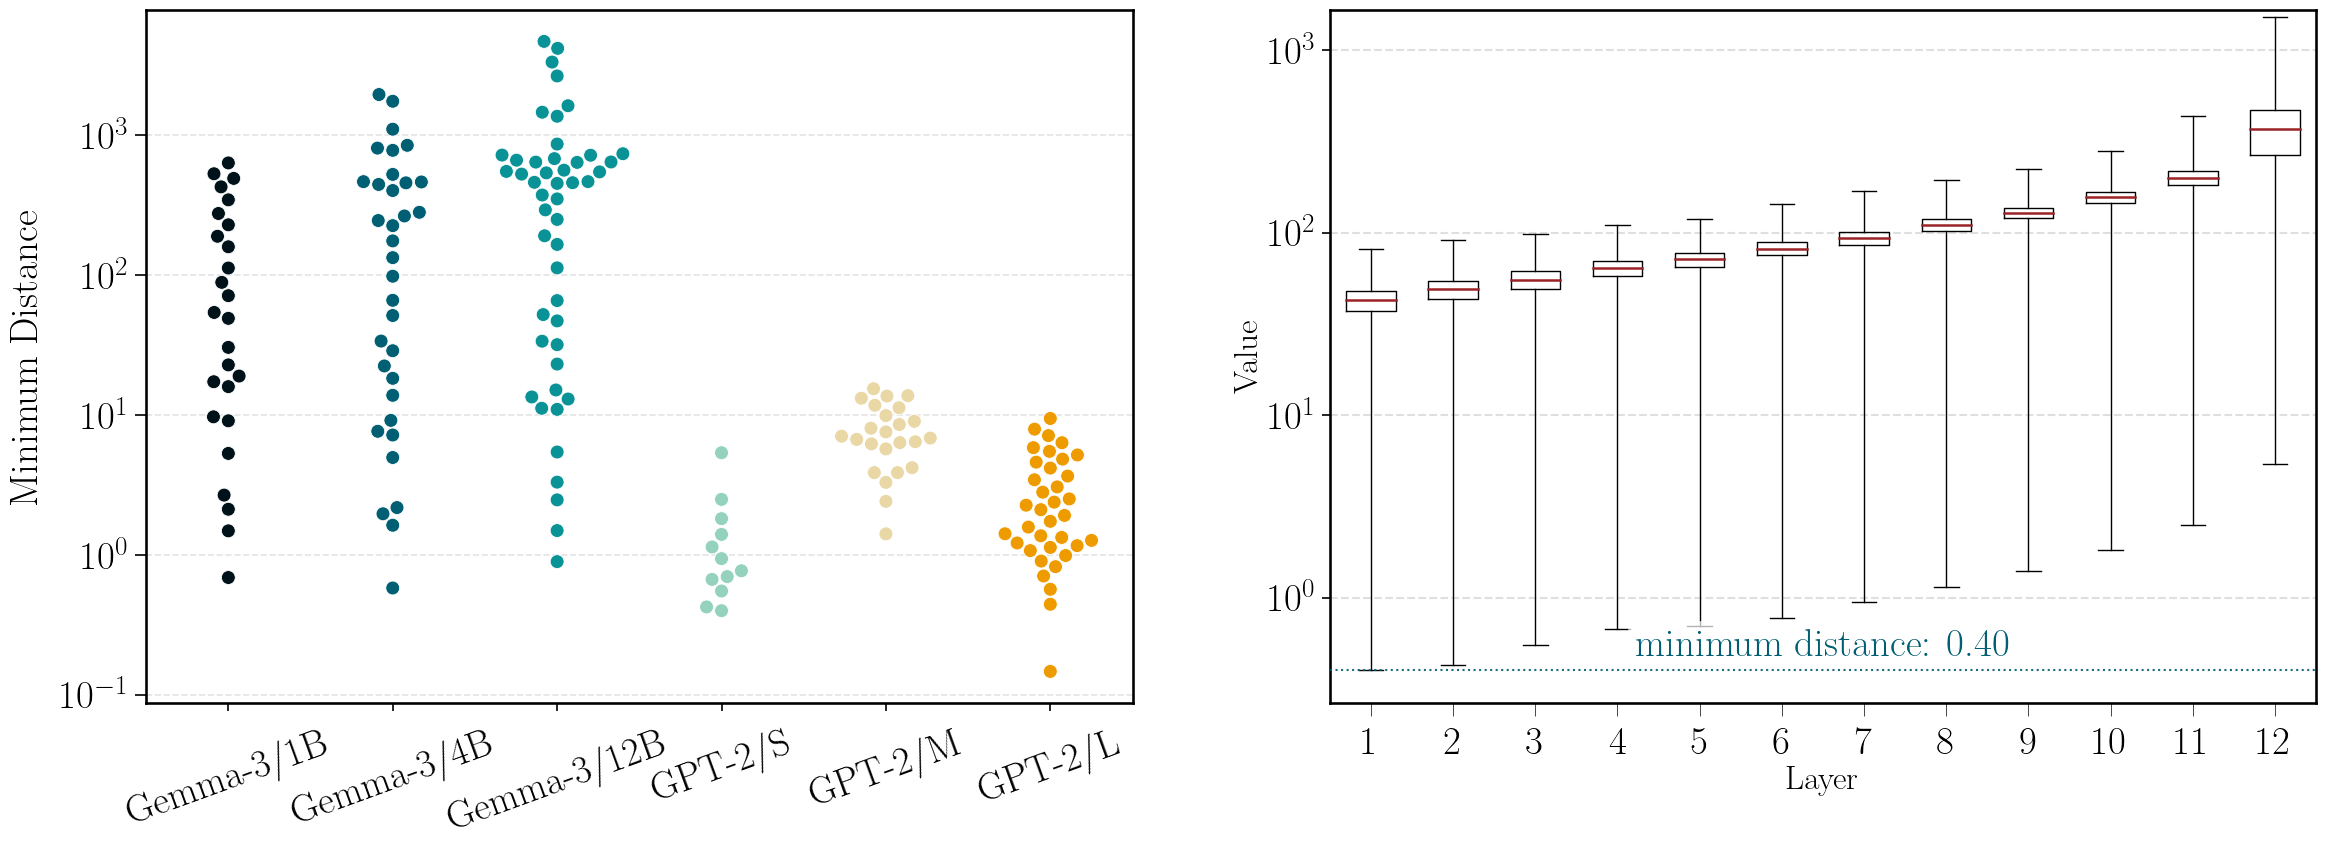

In [98]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(28, 9))

plot_swarm(swarm_df, y_key='min', ax=ax[0], figsize=(14, 9))
plot_model_boxplot(model_name_to_data['gpt2'], 'gpt2', ax=ax[1], figsize=(14, 9))

# save as pdf tight layout 
plt.savefig(os.path.join(output_dir, 'combined_swarm_boxplot.pdf'), dpi=300, bbox_inches='tight')